## Set up environment

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.random.mtrand import RandomState
from scipy.special import logsumexp
import scipy
import pandas as pd
from scipy.stats.distributions import beta
from copy import deepcopy
import gym, recogym
from recogym import env_1_args, Configuration
from recogym.agents import OrganicUserEventCounterAgent, organic_user_count_args
from recogym.agents.organic_count import OrganicCount, organic_count_args, to_categorical
from recogym import Configuration
from recogym.agents import Agent
from recogym.envs.observation import Observation
from recogym.agents import RandomAgent, random_args
from recogym import verify_agents, verify_agents_IPS
from recogym.evaluate_agent import plot_verify_agents, verify_agents_recall_at_k
import matplotlib.pyplot as plt

# Set style for pretty plots
plt.style.use('tableau-colorblind10')

P = 2000 # Number of Products
U = 2000 # Number of Users

# You can overwrite environment arguments here:
env_1_args['random_seed'] = 42
env_1_args['num_products']= P
env_1_args['phi_var']=0.0
env_1_args['number_of_flips']=P//2
env_1_args['sigma_mu_organic'] = 0.1
env_1_args['sigma_omega']=0.05
# Initialize the gym for the first time by calling .make() and .init_gym()
env = gym.make('reco-gym-v1')
env.init_gym(env_1_args)

env.reset()

In [2]:
# Generate RecSys logs for U users
reco_log = env.generate_logs(U)
reco_log.head(20)

,t,u,z,v,a,c,ps,ps-a
0,0,0,organic,445.0,NaN,NaN,NaN,None
1,1,0,organic,567.0,NaN,NaN,NaN,None
2,2,0,organic,1196.0,NaN,NaN,NaN,None
3,3,0,organic,285.0,NaN,NaN,NaN,None
4,4,0,organic,1116.0,NaN,NaN,NaN,None
5,5,0,organic,1658.0,NaN,NaN,NaN,None
6,6,0,organic,199.0,NaN,NaN,NaN,None
7,7,0,bandit,NaN,1367.0,0.0,0.0005,"[0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.000..."
8,8,0,bandit,NaN,1086.0,0.0,0.0005,"[0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.000..."
9,9,0,bandit,NaN,1698.0,0.0,0.0005,"[0.0005, 0.0005, 0.0005, 0.0005, 0.0005, 0.000..."


In [3]:
n_events = reco_log.shape[0]
n_organic = reco_log.loc[reco_log['z'] == 'organic'].shape[0]
print('Training on {0} organic and {1} bandit events'.format(n_organic, n_events - n_organic))

Training on 41830 organic and 157221 bandit events


## Traditional Evaluation

In [4]:
from recogym.envs.session import OrganicSessions
from recogym.envs.context import DefaultContext
from recogym.envs.observation import Observation

def leave_one_out(reco_log, agent, last = False, N = 1, folds = 10):
    # 1. Extract all organic events
    reco_log = reco_log.loc[reco_log['z'] == 'organic']
    
    # 2. For every user sequence - randomly sample out an item
    hits = []
    for _ in range(folds):
        user_id = 0
        history = []
        session = OrganicSessions()
        agent.reset()
        for row in reco_log.itertuples():
            # If we have a new user
            if row.u != user_id:
                if last:
                    # Sample out last item
                    index = len(history) - 1
                else:
                    # Sample out a random item from the history
                    index = np.random.choice(len(history),
                                             replace = False)
                test  = history[index]
                train = history[:index] + history[index + 1:]

                # 3. Recreate the user sequence without these items - Let the agent observe the incomplete sequence
                for t, v in list(train):
                    session.next(DefaultContext(t, user_id), int(v))

                # 4. Generate a top-N set of recommendations by letting the agent act
                # TODO - For now only works for N = 1
                try:
                    prob_a = agent.act(Observation(DefaultContext(t + 1, user_id), session), 0, False)['ps-a']
                except:
                    prob_a = [1 / P] * P

                # 5. Compute metrics checking whether the sampled test item is in the top-N
                hits.append(np.argmax(prob_a) == int(test[1]))

                # Reset variables
                user_id = row.u
                history = []
                session = OrganicSessions()
                agent.reset()

            # Save the organic interaction to the running average for the session
            history.append((row.t,row.v))
    
    # Error analysis
    mean_hits = np.mean(hits)
    serr_hits = np.std(hits) / np.sqrt(len(hits))
    low_bound = mean_hits - 1.96 * serr_hits
    upp_bound = mean_hits + 1.96 * serr_hits
    
    return mean_hits, low_bound, upp_bound

def verify_agents_traditional(reco_log, agents, last = False, N = 1, folds = 10):
    # Placeholder DataFrame for result
    stat = {
        'Agent': [],
        '0.025': [],
        '0.500' : [],
        '0.975': [],
    }

    # For every agent
    for agent_id in agents:
        # Compute HR@k
        mean, low, upp = leave_one_out(reco_log, agents[agent_id], last = last, N = N, folds = folds)
        stat['Agent'].append(agent_id)
        stat['0.025'].append(low)
        stat['0.500'].append(mean)
        stat['0.975'].append(upp)
    return pd.DataFrame().from_dict(stat)

## Counterfactual Evaluation

In [5]:
def compute_ips_weights(agent, reco_log):
    # Placeholder for return values
    rewards = [] # Labels for actions
    t_props = [] # Treatment propensities
    l_props = [] # Logging propensities
    
    # For every logged interaction
    user_id = 0
    session = OrganicSessions()
    agent.reset()
    for row in reco_log.itertuples():
        # If we have a new user
        if row.u != user_id:
            # Reset
            session = OrganicSessions()
            agent.reset()
            user_id = row.u
        
        # If we have an organic event
        if row.z == 'organic':
            session.next(DefaultContext(row.t, row.u), int(row.v))        
            
        else:
            prob_a = agent.act(Observation(DefaultContext(row.t, row.u), session), 0, False)['ps-a']
            rewards.append(row.c)
            t_props.append(prob_a[int(row.a)])
            l_props.append(row.ps)
            session = OrganicSessions()
    
    return np.asarray(rewards), np.asarray(t_props), np.asarray(l_props)

def verify_agents_counterfactual(reco_log, agents, cap = 3):
    # Placeholder DataFrame for results
    IPS_stat = {
        'Agent': [],
        '0.025': [],
        '0.500' : [],
        '0.975': [],
    }
    CIPS_stat = {
        'Agent': [],
        '0.025': [],
        '0.500' : [],
        '0.975': [],
    }
    SNIPS_stat = {
        'Agent': [],
        '0.025': [],
        '0.500' : [],
        '0.975': [],
    }

    # For every agent
    for agent_id in agents:
        # Get the rewards and propensities
        rewards, t_props, l_props = compute_ips_weights(agents[agent_id], reco_log)
        
        # Compute the sample weights - propensity ratios
        p_ratio = t_props / l_props

        # Effective sample size for E_t estimate (from A. Owen)
        n_e = len(rewards) * (np.mean(p_ratio) ** 2) / (p_ratio ** 2).mean()
        
        # Critical value from t-distribution as we have unknown variance
        alpha = .00125
        cv = scipy.stats.t.ppf(1 - alpha, df = int(n_e) - 1)
        
        ###############
        # VANILLA IPS #
        ###############
        # Expected reward for pi_t
        E_t = np.mean(rewards * p_ratio)

        # Variance of the estimate
        var = ((rewards * p_ratio - E_t) ** 2).mean()
        stddev = np.sqrt(var)
        
        # C.I. assuming unknown variance - use t-distribution and effective sample size
        min_bound = E_t - cv * stddev / np.sqrt(int(n_e))
        max_bound = E_t + cv * stddev / np.sqrt(int(n_e))
        
        # Store result
        IPS_stat['Agent'].append(agent_id)
        IPS_stat['0.025'].append(min_bound)
        IPS_stat['0.500'].append(E_t)
        IPS_stat['0.975'].append(max_bound)
        
        ############## 
        # CAPPED IPS #
        ##############
        # Cap ratios
        p_ratio_capped = np.clip(p_ratio, a_min = None, a_max = cap)
        
        # Expected reward for pi_t
        E_t_capped = np.mean(rewards * p_ratio_capped)

        # Variance of the estimate
        var_capped = ((rewards * p_ratio_capped - E_t_capped) ** 2).mean()
        stddev_capped = np.sqrt(var_capped)        
        
        # C.I. assuming unknown variance - use t-distribution and effective sample size
        min_bound_capped = E_t_capped - cv * stddev_capped / np.sqrt(int(n_e))
        max_bound_capped = E_t_capped + cv * stddev_capped / np.sqrt(int(n_e))
        
        # Store result
        CIPS_stat['Agent'].append(agent_id)
        CIPS_stat['0.025'].append(min_bound_capped)
        CIPS_stat['0.500'].append(E_t_capped)
        CIPS_stat['0.975'].append(max_bound_capped)
        
        ##############
        # NORMED IPS #
        ##############
        # Expected reward for pi_t
        E_t_normed = np.sum(rewards * p_ratio) / np.sum(p_ratio)

        # Variance of the estimate
        var_normed = np.sum(((rewards - E_t_normed) ** 2) * (p_ratio ** 2)) / (p_ratio.sum() ** 2)    
        stddev_normed = np.sqrt(var_normed)

        # C.I. assuming unknown variance - use t-distribution and effective sample size
        min_bound_normed = E_t_normed - cv * stddev_normed / np.sqrt(int(n_e))
        max_bound_normed = E_t_normed + cv * stddev_normed / np.sqrt(int(n_e))

        # Store result
        SNIPS_stat['Agent'].append(agent_id)
        SNIPS_stat['0.025'].append(min_bound_normed)
        SNIPS_stat['0.500'].append(E_t_normed)
        SNIPS_stat['0.975'].append(max_bound_normed)
        
    return pd.DataFrame().from_dict(IPS_stat), pd.DataFrame().from_dict(CIPS_stat), pd.DataFrame().from_dict(SNIPS_stat)

## A simple SVD Agent

In [6]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

class SVDAgent(Agent):
    def __init__(self, config, U = U, P = P, K = 5):
        super(SVDAgent, self).__init__(config)
        self.rng = RandomState(self.config.random_seed)
        assert(P >= K)
        self.K = K
        self.R = csr_matrix((U,P))
        self.V = np.zeros((P,K))
        self.user_history = np.zeros(P)
    
    def train(self, reco_log, U = U, P = P):
        # Extract all organic user logs
        reco_log = reco_log.loc[reco_log['z'] == 'organic']
        
        # Generate ratings matrix for training, row-based for efficient row (user) retrieval
        self.R = csr_matrix((np.ones(len(reco_log)),
                            (reco_log['u'],reco_log['v'])),
                            (U,P))

        # Singular Value Decomposition
        _, _, self.V = svds(self.R, k = self.K)
        
    def observe(self, observation):
        for session in observation.sessions():
            self.user_history[session['v']] += 1

    def act(self, observation, reward, done):
        """Act method returns an Action based on current observation and past history"""
        self.observe(observation)
        scores = self.user_history.dot(self.V.T).dot(self.V)
        action = np.argmax(scores)
        prob = np.zeros_like(scores)
        prob[action] = 1.0

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': prob[action],
                'ps-a': prob,
            },
        }

    def reset(self):
        self.user_history = np.zeros(P)

## A simple item-kNN Agent

In [7]:
from itertools import chain
from sklearn.neighbors import NearestNeighbors

class itemkNNAgent(Agent):
    def __init__(self, config, U = U, P = P, k = 5, greedy = False, alpha = 1):
        super(itemkNNAgent, self).__init__(config)
        self.rng = RandomState(self.config.random_seed)
        self.k = min(P,k)
        self.greedy = greedy
        self.alpha = alpha
        self.Rt = csr_matrix((P,U))
        self.user_history = np.zeros(P)
        self.S = np.eye(P)
    
    def train(self, reco_log, U = U, P = P):
        # Extract all organic user logs
        reco_log = reco_log.loc[reco_log['z'] == 'organic']
        
        # Generate ratings matrix for training, row-based for efficient row (user) retrieval
        self.R_t = csr_matrix((np.ones(len(reco_log)),
                              (reco_log['v'],reco_log['u'])),
                              (P,U))

        # Set up nearest neighbours module
        nn = NearestNeighbors(n_neighbors = self.k,
                              metric = 'cosine')

        # Initialise placeholder for distances and indices
        distances = []
        indices   = []

        # Dirty fix for multiprocessing backend being unable to pickle large objects
        nn.fit(self.R_t)
        distances, indices = nn.kneighbors(self.R_t, return_distance = True)

        # Precompute similarity matrix S
        data = list(chain.from_iterable(1.0 - distances))
        rows = list(chain.from_iterable([i] * self.k for i in range(P)))
        cols = list(chain.from_iterable(indices))
        
        # (P,P)-matrix with cosine similarities between items
        self.S = csr_matrix((data,(rows, cols)), (P,P)).todense()
        
    def observe(self, observation):
        for session in observation.sessions():
            self.user_history[session['v']] += 1

    def act(self, observation, reward, done):
        """Act method returns an Action based on current observation and past history"""
        self.observe(observation)
        scores = self.user_history.dot(self.S).A1
        
        if self.greedy:
            action = np.argmax(scores)
            prob = np.zeros_like(scores)
            prob[action] = 1.0
        else:
            scores **= self.alpha
            prob = scores / np.sum(scores)
            action = self.rng.choice(self.S.shape[0], p = prob)

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': prob[action],
                'ps-a': prob,
            },
        }

    def reset(self):
        self.user_history = np.zeros(P)

## A simple user-kNN Agent

In [8]:
class userkNNAgent(Agent):
    def __init__(self, config, U = U, P = P, k = 5, greedy = False, alpha = 1):
        super(userkNNAgent, self).__init__(config)
        self.rng = RandomState(self.config.random_seed)
        self.k = min(P,k)
        self.greedy = greedy
        self.alpha = alpha
        self.U = U
        self.P = P
        self.R = csr_matrix((U,P))
        self.user_history = np.zeros(P)
        self.nn = NearestNeighbors(n_neighbors = self.k, metric = 'cosine')
        
    def train(self, reco_log, U = U, P = P):
        # Extract all organic user logs
        reco_log = reco_log.loc[reco_log['z'] == 'organic']
        
        # Generate ratings matrix for training, row-based for efficient row (user) retrieval
        self.R = csr_matrix((np.ones(len(reco_log)),
                            (reco_log['u'],reco_log['v'])),
                            (U,P))

        # Fit nearest neighbours
        self.nn.fit(self.R)
        
    def observe(self, observation):
        for session in observation.sessions():
            self.user_history[session['v']] += 1

    def act(self, observation, reward, done):
        """Act method returns an Action based on current observation and past history"""
        self.observe(observation)
        
        # Get neighbouring users based on user history
        distances, indices = self.nn.kneighbors(self.user_history.reshape(1,-1))
        scores = np.add.reduce([dist * self.R[idx,:] for dist, idx in zip(distances,indices)])
        
        if self.greedy:
            action = np.argmax(scores)
            prob = np.zeros_like(scores)
            prob[action] = 1.0
        else:
            scores **= self.alpha
            prob = scores / np.sum(scores)
            action = self.rng.choice(self.P, p = prob)

        return {
            **super().act(observation, reward, done),
            **{
                'a': action,
                'ps': prob[action],
                'ps-a': prob,
            },
        }

    def reset(self):
        self.user_history = np.zeros(P)

## Initialise and train agents

In [9]:
%%time
# SVD Agent
SVD_agent = SVDAgent(Configuration(env_1_args), U, P, 30)
SVD_agent.train(reco_log)

# item-kNN Agent
itemkNN_agent = itemkNNAgent(Configuration(env_1_args), U, P, 500, greedy = True)
itemkNN_agent.train(reco_log)

# user-kNN Agent
userkNN_agent = userkNNAgent(Configuration(env_1_args), U, P, 20, greedy = True)
userkNN_agent.train(reco_log)

# Generalised Popularity agent
GPOP_agent = OrganicCount(Configuration({
    **env_1_args,
    'select_randomly': True,
}))

# Generalised Popularity agent
GPOP_agent_greedy = OrganicCount(Configuration({
    **env_1_args,
    'select_randomly': False,
}))

# Peronalised Popularity agent
PPOP_agent = OrganicUserEventCounterAgent(Configuration({
    **organic_user_count_args,
    **env_1_args,
    'select_randomly': True,
}))

# Peronalised Popularity agent
PPOP_agent_greedy = OrganicUserEventCounterAgent(Configuration({
    **organic_user_count_args,
    **env_1_args,
    'select_randomly': False,
}))

# Random Agent
random_args['num_products'] = P
RAND_agent = RandomAgent(Configuration({**env_1_args, **random_args,}))

CPU times: user 2.2 s, sys: 3.11 s, total: 5.31 s
Wall time: 1.04 s


# Offline Evaluation
All of the above is quite recognisable from earlier parts of the course, but now here things differ.
We will use the logged feedback we obtained from the recommender system to evaluate the agents we defined earlier.

In [10]:
%%time
from IPython.display import display, HTML
# Placeholder for agents
agents = {
    '    Random': RAND_agent,
    '   Popular': GPOP_agent_greedy,
    '   User-pop': PPOP_agent,
    '  SVD':  SVD_agent,
    ' User-kNN': userkNN_agent,
    'Item-kNN': itemkNN_agent,
}
agent_ids = sorted(list(agents.keys()))#['SVD','GPOP','PPOP','RAND']
# Generate new logs, to be used for offline testing
n_test_users = 5000 # U
test_log = env.generate_logs(n_test_users)
n_events = test_log.shape[0]
n_organic = test_log.loc[test_log['z'] == 'organic'].shape[0]
print('Testing on {0} organic and {1} bandit events'.format(n_organic, n_events - n_organic))

Testing on 104953 organic and 392999 bandit events
CPU times: user 1h 43s, sys: 2h 12min 23s, total: 3h 13min 7s
Wall time: 6min 3s


## Leave-One-Out

In [21]:
from matplotlib.ticker import FormatStrFormatter

def plot_barchart(result, title, xlabel,  col = 'tab:red', figname = 'fig.eps', size = (6,2), fontsize = 12):
    fig, axes = plt.subplots(figsize = size)
    plt.title(title, size = fontsize)
    n_agents = len(result)
    yticks = np.arange(n_agents)
    mean = result['0.500']
    lower = result['0.500'] - result['0.025']
    upper = result['0.975'] - result['0.500']
    plt.barh(yticks,
             mean,
             height = .25,
             xerr  = (lower, upper),
             align = 'center',
             color = col,)
    plt.yticks(yticks, result['Agent'], size = fontsize)
    plt.xticks(size = fontsize)
    plt.xlabel(xlabel, size = fontsize)
    plt.xlim(.0,None)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.savefig(figname, bbox_inches = 'tight')
    plt.show()

/home/ojeunen/ojeunen_add_venv/lib/python3.6/site-packages/recogym/agents/organic_user_count.py:36: RuntimeWarning: invalid value encountered in true_divide
  action_proba = features / np.sum(features, axis = 0)


,Agent,0.025,0.500,0.975
0,Random,0.000090,0.000220,0.000350
1,Popular,0.000002,0.000080,0.000158
2,User-pop,0.068960,0.071214,0.073469
3,SVD,0.070813,0.073095,0.075376
4,User-kNN,0.080282,0.082697,0.085111
5,Item-kNN,0.073199,0.075515,0.077831


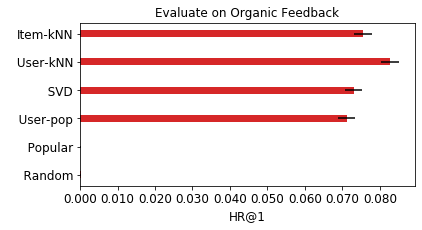

CPU times: user 32min 58s, sys: 20min 11s, total: 53min 9s
Wall time: 4min 2s


In [12]:
%%time
result_LOO = verify_agents_traditional(test_log, deepcopy(agents))
display(result_LOO)
plot_barchart(result_LOO, 'Evaluate on Organic Feedback', 'HR@1', 'tab:red', 'traditional_eval.eps')

## IPS Estimators

### $\pi_0 = \text{ppop}$

,Agent,0.025,0.500,0.975
0,Random,0.000138,0.000150,0.000162
1,Popular,-0.035542,0.000139,0.035820
2,User-pop,0.016330,0.016951,0.017572
3,SVD,0.004552,0.012766,0.020979
4,User-kNN,0.010291,0.017362,0.024433
5,Item-kNN,0.012949,0.019375,0.025801


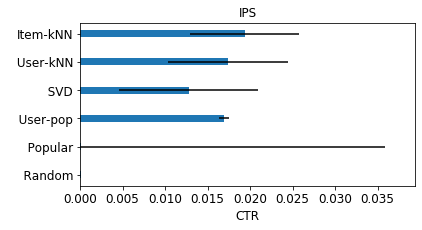

,Agent,0.025,0.500,0.975
0,Random,0.000138,0.000150,0.000162
1,Popular,-0.009693,0.000038,0.009769
2,User-pop,0.016330,0.016951,0.017572
3,SVD,0.005199,0.011509,0.017819
4,User-kNN,0.010462,0.016227,0.021992
5,Item-kNN,0.012711,0.018181,0.023651


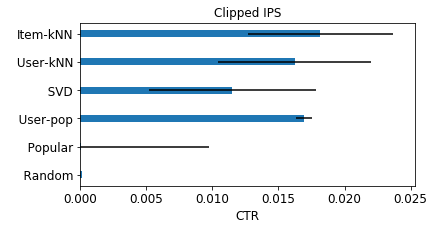

CPU times: user 3h 39min 56s, sys: 3h 45min 21s, total: 7h 25min 17s
Wall time: 24min 5s


In [13]:
%%time
# Generate new logs, to be used for offline testing
test_log_ppop = env.generate_logs(n_test_users, agent = deepcopy(PPOP_agent))
cap = 15
result_IPS, result_CIPS, result_SNIPS = verify_agents_counterfactual(test_log_ppop, deepcopy(agents), cap = cap)
display(result_IPS)
plot_barchart(result_IPS, 'IPS', 'CTR', 'tab:blue', 'bandit_eval_noclip.eps')
display(result_CIPS)
plot_barchart(result_CIPS, 'Clipped IPS', 'CTR', 'tab:blue', 'bandit_eval_clip{0}.eps'.format(cap))

## A/B-Tests

,Agent,0.025,0.500,0.975
0,Random,0.009599,0.009904,0.010215
1,Popular,0.009620,0.009925,0.010236
2,User-pop,0.016459,0.016859,0.017265
3,SVD,0.017847,0.018263,0.018685
4,User-kNN,0.018301,0.018723,0.019151
5,Item-kNN,0.018537,0.018961,0.019392


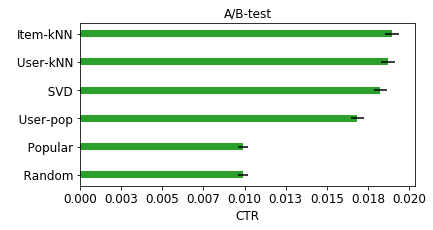

CPU times: user 10h 56min 27s, sys: 20h 1min 30s, total: 1d 6h 57min 57s
Wall time: 58min 57s


In [14]:
%%time
result_AB = verify_agents(env, n_test_users, deepcopy(agents))
display(result_AB)
plot_barchart(result_AB, 'A/B-test', 'CTR', 'tab:green', 'ABtest_eval.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


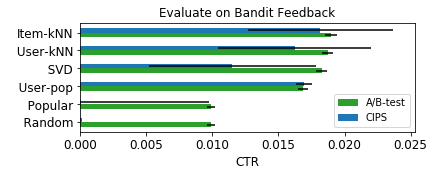

In [20]:
from matplotlib.ticker import FormatStrFormatter

def combine_barchart(resultAB, resultCIPS, title, xlabel,  figname = 'fig.eps', size = (6,2), fontsize = 12):
    fig, axes = plt.subplots(figsize = size)
    plt.title(title, size = fontsize)
    n_agents = len(resultAB)
    
    for i, (name, colour, result) in enumerate([('A/B-test', 'tab:green', result_AB),('CIPS', 'tab:blue', result_CIPS)]):
        mean = result['0.500']
        lower = result['0.500'] - result['0.025']
        upper = result['0.975'] - result['0.500']
        height = .25
        yticks = [a + i * height for a in range(n_agents)]
        plt.barh(yticks,
                 mean,
                 height = height,
                 xerr  = (lower, upper),
                 align = 'edge',
                 label = name,
                 color = colour)
    plt.yticks(yticks, result['Agent'], size = fontsize)
    plt.xticks(size = fontsize)
    plt.xlabel(xlabel, size = fontsize)
    plt.legend(loc = 'lower right')
    plt.xlim(.0,None)
    plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    plt.savefig(figname, bbox_inches = 'tight')
    plt.show()
combine_barchart(result_AB, result_CIPS, 'Evaluate on Bandit Feedback', 'CTR', 'ABtest_CIPS.eps')

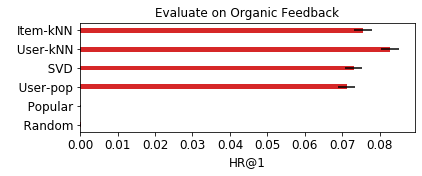

In [22]:
plot_barchart(result_LOO, 'Evaluate on Organic Feedback', 'HR@1', 'tab:red', 'traditional_eval.eps')